In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
file="chr1/AalbF5_walk.txt"

data = pd.read_csv(file, header=None, names=["left", "right"], dtype=int)
data["degree"] = data["right"] + data["left"]

In [ ]:
rolling = data.rolling(window=1_000, step=500).mean()

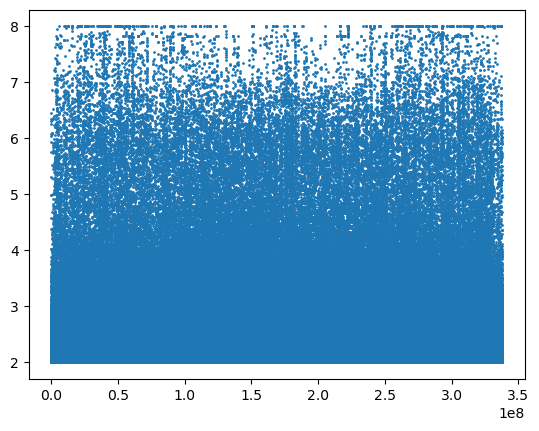

In [ ]:
plt.scatter(rolling.index, rolling["degree"], s=1)

In [ ]:
k = 31

### AalbF5 chromosome 1
# based on fasta file
nb_nucleotides = 338_177_654    # grep -v '^>' AalbF5_chr1.fna | tr -d '\n' | wc -c     # coincides exactly with NCBI indication
nb_ACGT = 155_552_214           # grep -v '^>' AalbF5_chr1.fna | tr -cd ACGT | wc -c
nb_acgt = 182_182_218           # grep -v '^>' AalbF5_chr1.fna | tr -cd acgt | wc -c
nb_N = 443_222                  # grep -v '^>' AalbF5_chr1.fna | tr -cd N | wc -c

nb_patches_N = 8562             # grep -v '^>' AalbF5_chr1.fna | grep -oP 'N+'| wc -l   # note: pb with patches gapping lines/ at start or end of seq

# based on rust code
nb_total_31mers = 337_698_822   # with duplicates           # coincides ~ with: nb_nucleotides - nb_N - (k-1) * (nb_patches_N+1)
nb_nocan_31mers = 247_347_254   # without duplicates
nb_canon_31mers = 232_971_101   # without duplicates

### graph AalbF3 + AalbF5 (k31, canonical)
nb_nodes = 376_592_961
nb_edges = 383_504_450

### graph AalbF5 (k31, canonical)
nb_nodes = 232_971_101
nb_edges = 236_446_568

### graph AalbF5 (k32, canonical)
nb_nodes = 235_350_021

### walktrough of AalbF5 (canonical)
nb_breaks_one_haplo = 46_619_218
nb_breaks_two_haplo = 55_574_344


In [17]:
(383_504_450 - 235_350_021) / 383_504_450

0.38631736606967665

In [14]:
# AalbF3
size_h1 = 373823221
break_h1_g1 = 52598113
break_h1_g12 = 60820242

# AalbF5
size_h2 = 337698822
break_h2_g2 = 46619218
break_h2_g12 = 55574344

In [16]:
# percentage of break added when combining graph 1 and 2
break_single = break_h1_g1 + break_h2_g2
break_together = break_h1_g12 + break_h2_g12

percentage = (break_together - break_single) / break_together * 100
print(f"Percentage of break added when combining graph 1 and 2: {percentage:.2f}%")

Percentage of break added when combining graph 1 and 2: 14.76%
